In [7]:
# !pip install imageio
# !pip install scikit-image

In [49]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity
import numpy as np
import scipy.ndimage as nd
from skimage.measure import block_reduce
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from IPython.display import Image

In [9]:
austen = io.imread('https://dl.airtable.com/S1InFmIhQBypHBL0BICi_austen.jpg')
austen_grayscale = rescale_intensity(color.rgb2gray(austen))
austen_grayscale.shape

(400, 400)

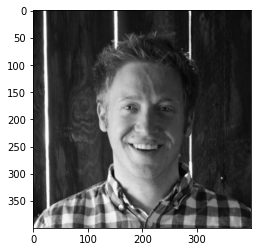

In [25]:
plt.imshow(austen_grayscale, cmap='gray');

In [18]:
horizontal_edge_convolution = np.array([[1,1,1],
                                        [0,0,0],
                                        [-1,-1,-1]])
vertical_edge_convolution = np.array([[1,0,-1],
                                      [1,0,-1],
                                      [1,0,-1]])
# diagonal_edge_convolution = np.array([[1,0,0,-1],
#                                       [0,1,-1,0],
#                                       [0,-1,1,0],
#                                       [-1,0,0,1]])

austen_horizontal = nd.convolve(austen_grayscale, horizontal_edge_convolution)
austen_vertical = nd.convolve(austen_grayscale, vertical_edge_convolution)

austen_edges_horz.shape

(400, 400)

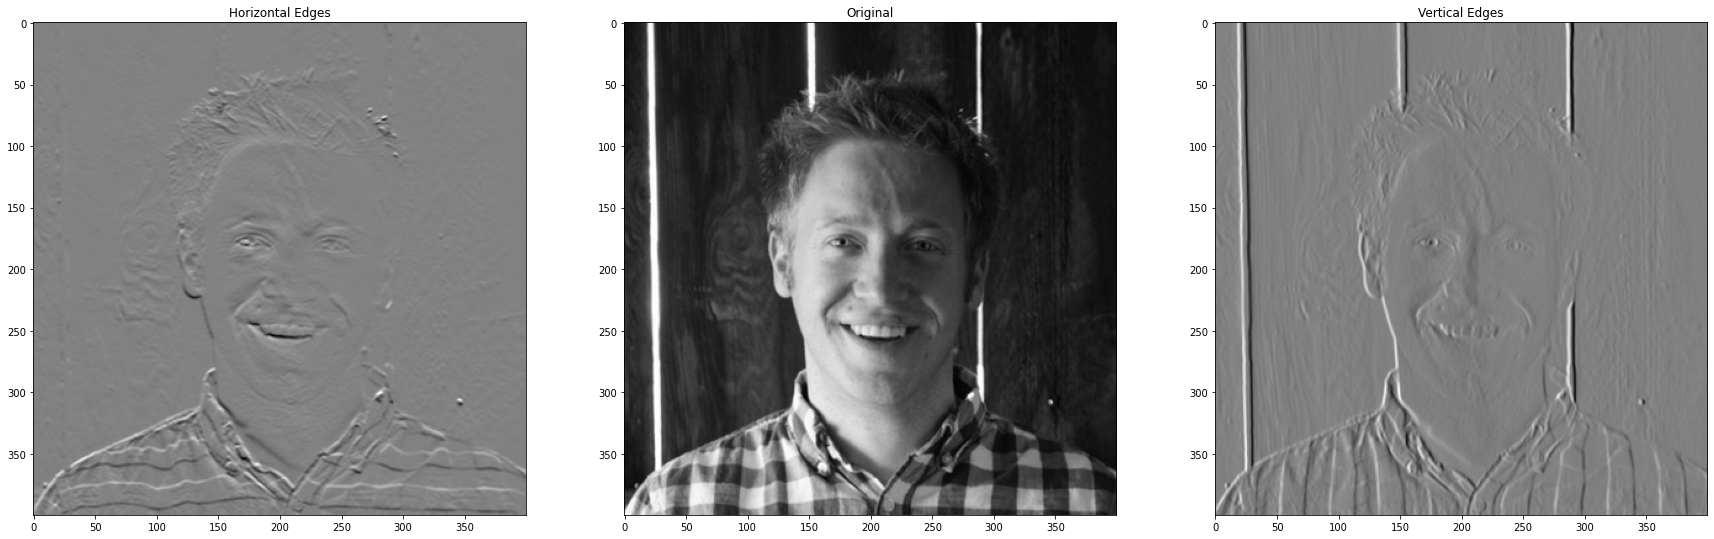

In [26]:
plt.figure(figsize=(30,10))
labels = ['Horizontal Edges', 'Original', 'Vertical Edges']
images = [austen_horizontal, austen_grayscale, austen_vertical]

i = 0
for label, image in zip(labels, images):
    plt.subplot(1,3,i+1)
    plt.grid(False)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    i += 1
plt.show()

(200, 200)

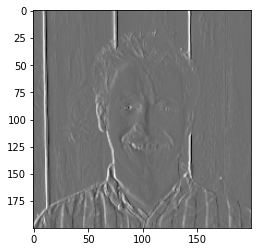

In [31]:
reduced = block_reduce(austen_vertical, (2,2), np.max)
plt.imshow(reduced, cmap='gray');
reduced.shape

In [36]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

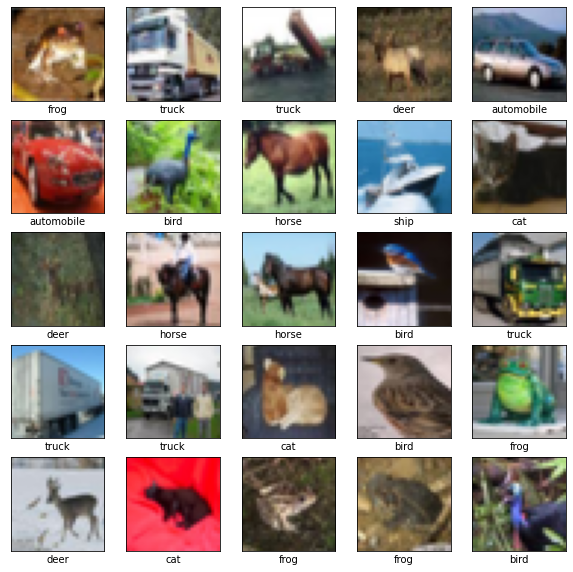

In [37]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # the cifar labels happen to be arrays, which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [38]:
train_images[0].shape #RGB

(32, 32, 3)

In [39]:
train_labels[1]

array([9], dtype=uint8)

In [41]:
# setup architecture
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [42]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.5073 - accuracy: 0.4526 - val_loss: 1.2178 - val_accuracy: 0.5624
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1227 - accuracy: 0.6017 - val_loss: 1.0969 - val_accuracy: 0.6126
Epoch 3/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9786 - accuracy: 0.6584 - val_loss: 1.0046 - val_accuracy: 0.6508
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8840 - accuracy: 0.6906 - val_loss: 0.9661 - val_accuracy: 0.6663
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8147 - accuracy: 0.7137 - val_loss: 0.9549 - val_accuracy: 0.6732
Epoch 6/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7610 - accuracy: 0.7341 - val_loss: 0.9248 - val_accuracy: 0.6868
Epoch 7/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7129 - accuracy: 0.7503 - val_loss: 0.8857 -

In [44]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 3s - loss: 0.8877 - accuracy: 0.7084 - 3s/epoch - 10ms/step


In [47]:
def process_img_path(img_path):
    return image.load_img(img_path, target_size=(224,224))

def img_contains_banana(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    model = ResNet50(weights='imagenet')
    features = model.predict(x)
    results = decode_predictions(features, top=3)[0]
    print(results)
    for entry in results:
        if entry[1] == 'banana':
            return entry[2]
    return 0.0

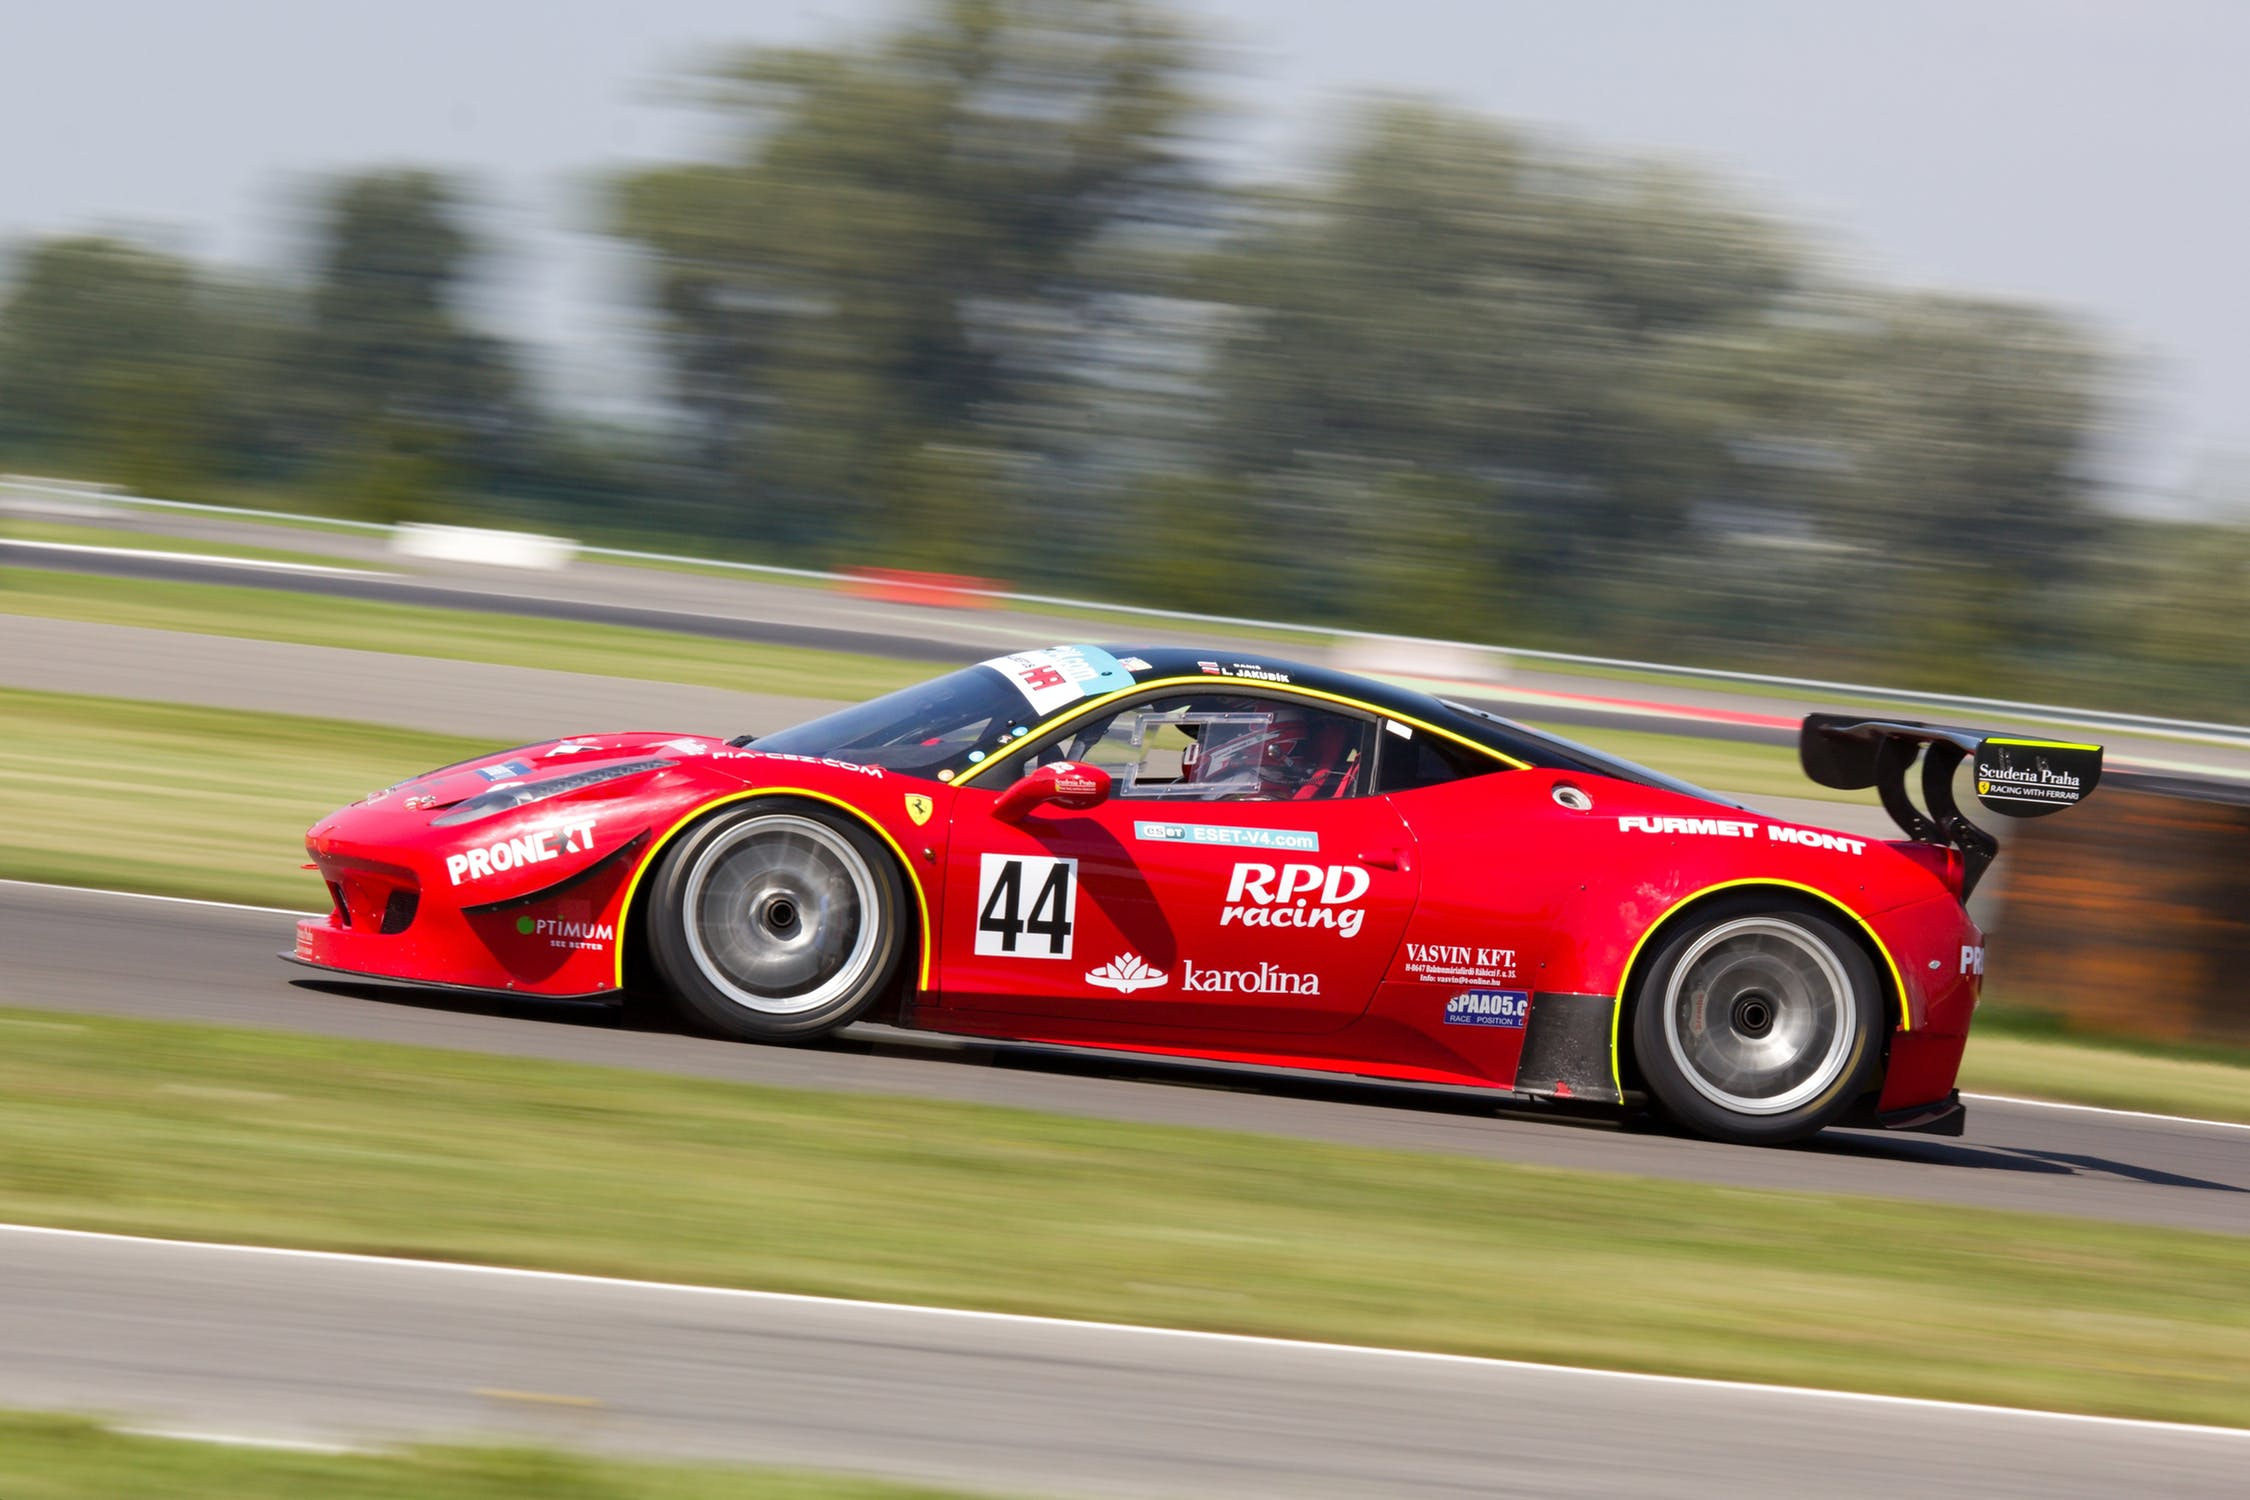

In [50]:
Image(filename='./example0.jpg', width=600)

In [51]:
img_contains_banana(process_img_path('example0.jpg'))

[('n04037443', 'racer', 0.9256286), ('n04285008', 'sports_car', 0.07028751), ('n04461696', 'tow_truck', 0.0021220376)]


0.0

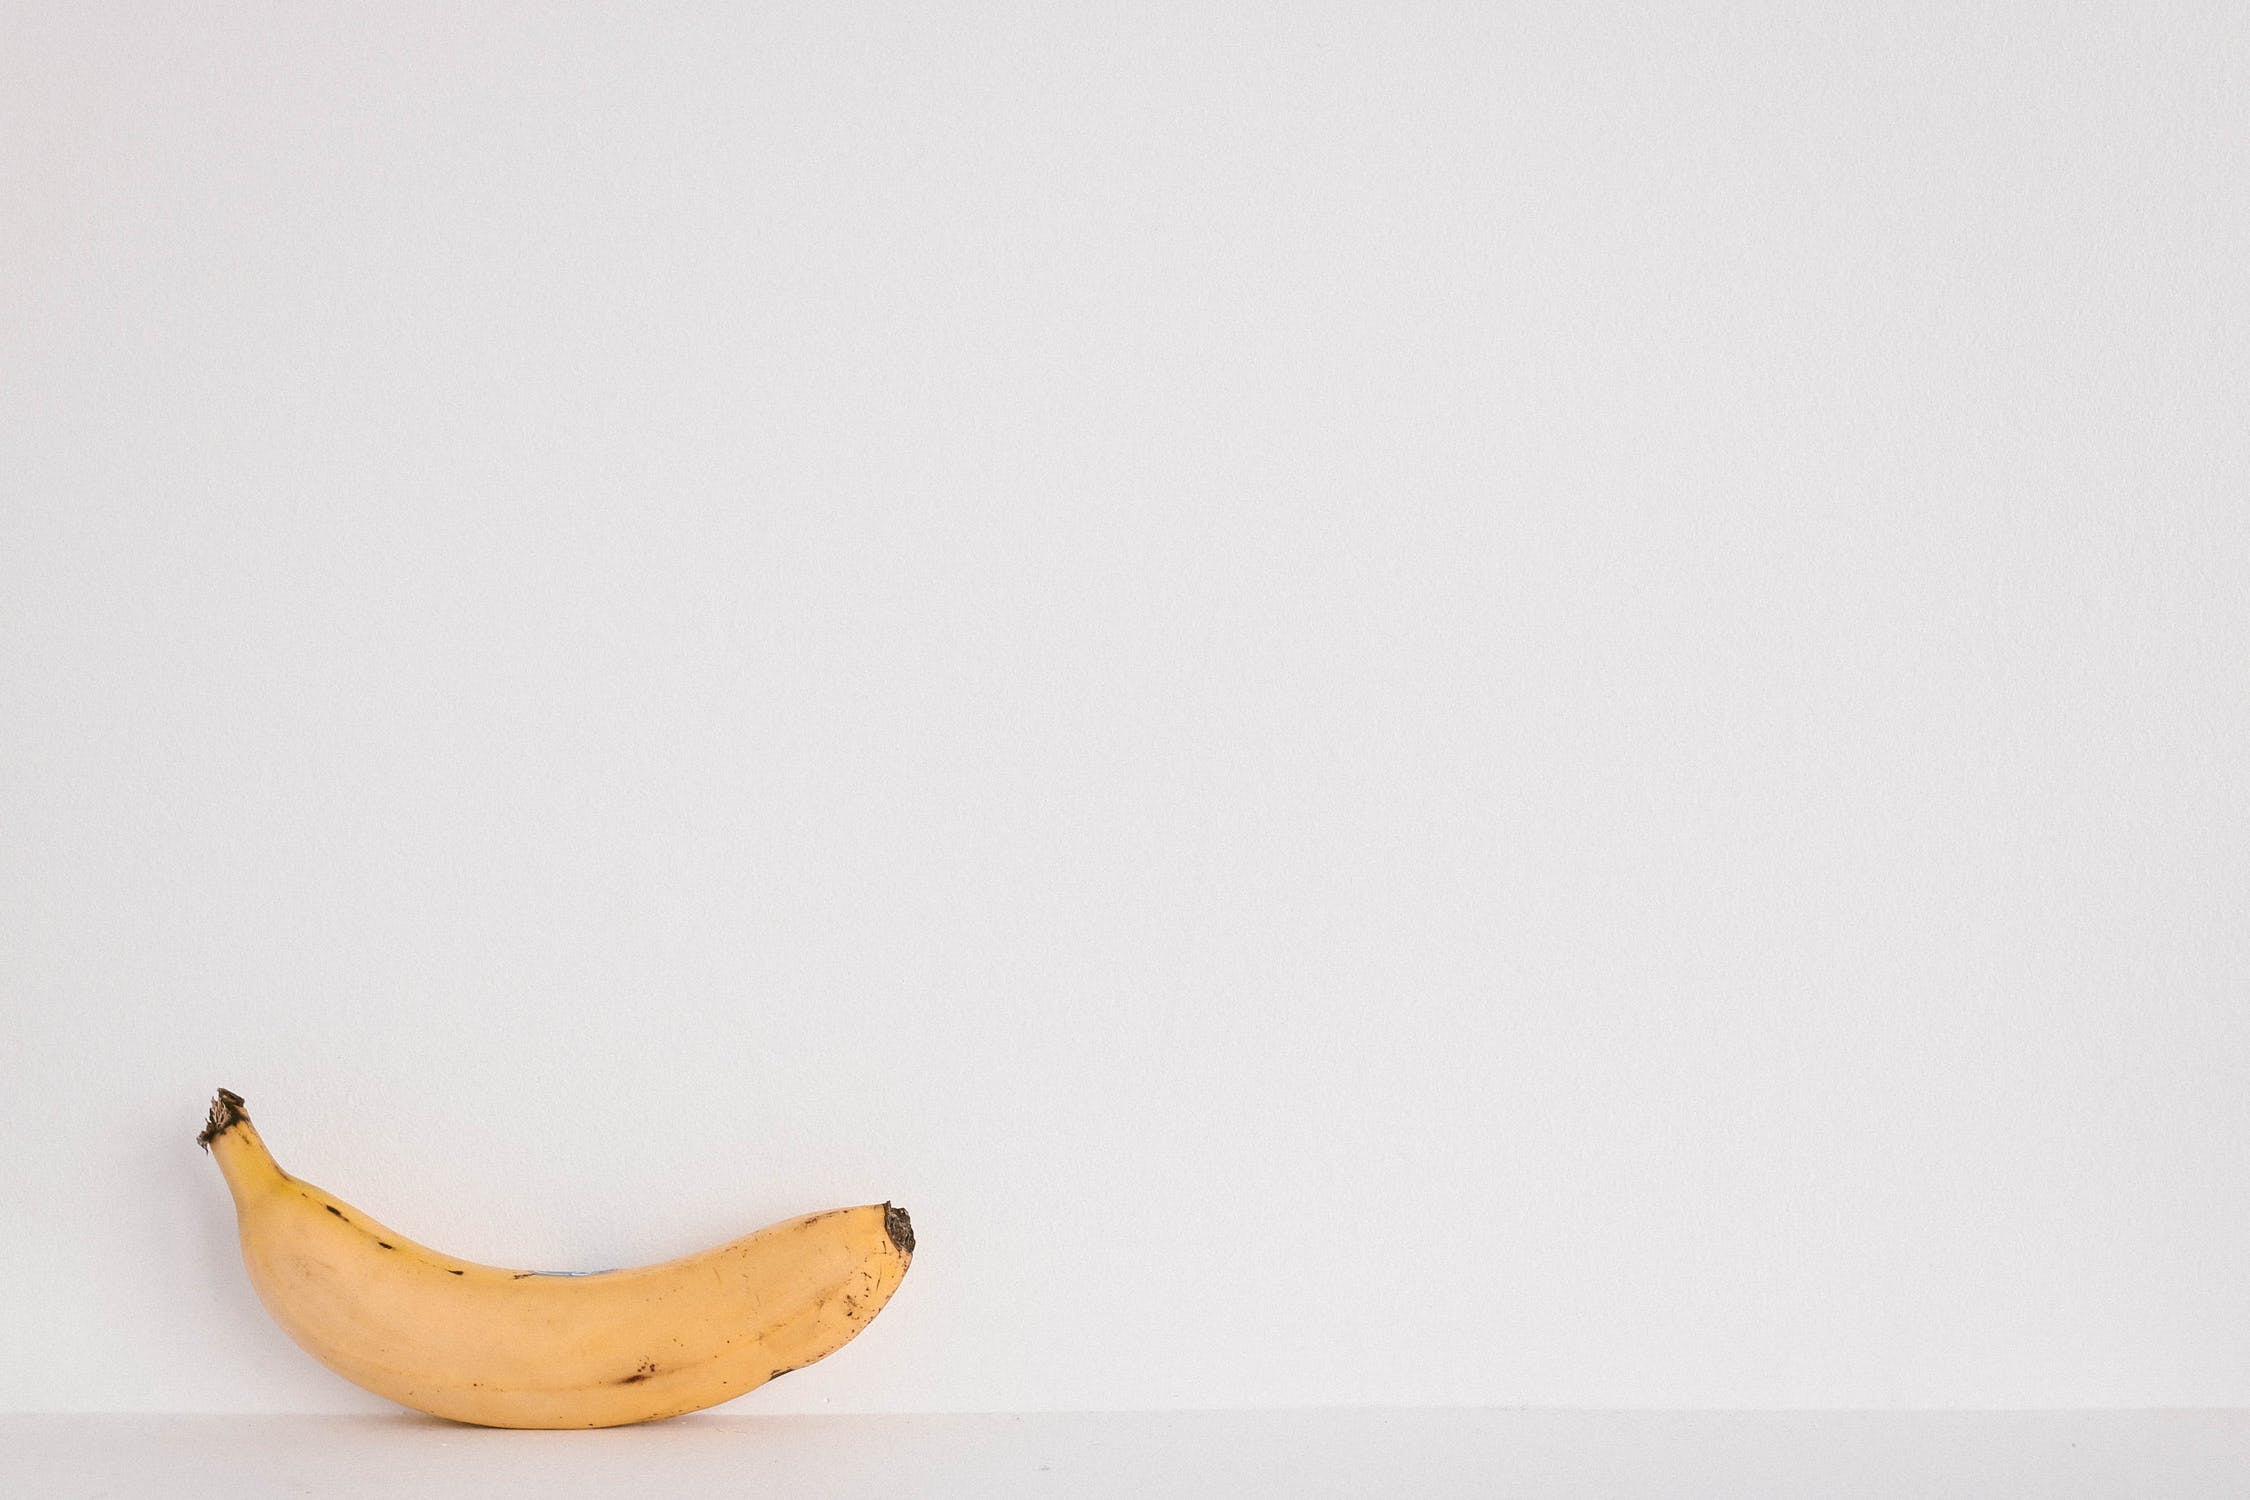

In [52]:
Image(filename='./example1.jpg', width=600)

In [53]:
img_contains_banana(process_img_path('example1.jpg'))

[('n03532672', 'hook', 0.077739365), ('n07753592', 'banana', 0.070150636), ('n03498962', 'hatchet', 0.06332075)]


0.070150636

In [54]:
# prob low because most of the image is not banana